# Predict Heavy Equipment Auction Price

## Case Study Goal
Predict the sale price of a particular piece of heavy equipment at auction based
on it's usage, equipment type, and configuration.  The data is sourced from auction
result postings and includes information on usage and equipment configurations.

## Evaluation
The evaluation of your model will be based on Root Mean Squared Log Error.
Which is computed as follows:

![Root Mean Squared Logarithmic Error](images/rmsle.png)

where *p<sub>i</sub>* are the predicted values (predicted auction sale prices) 
and *a<sub>i</sub>* are the actual values (the actual auction sale prices).

Note that this loss function is sensitive to the *ratio* of predicted values to
the actual values, a prediction of 200 for an actual value of 100 contributes
approximately the same amount to the loss as a prediction of 2000 for an actual
value of 1000.  To convince yourself of this, recall that a difference of
logarithms is equal to a single logarithm of a ratio, and rewrite each summand
as a single logarithm of a ratio.

This loss function is implemented in score_model.py.

## Data
The data for this case study are in `./data`. Although there are both training
and testing data sets, the testing data set should only be utilized to evaluate
your final model performance at the end of the day.  Think about it as your
hold out set.  Use cross-validation on the training data set to identify your
best model and then score your best model on the test data at the end of the day.
By using the same test data and the same evaluation metric (RMSLE) the relative
performance of different group's models on this case study can be assessed.

A data dictionary is included that explains the columns in the data.

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
def getNullCount(df:pd.DataFrame) -> None:
    """Prints metrics of null values from a dataframe"""
    columns = df.columns
    for col in columns:
        total_nan = sum(pd.isna(df[col]))
        total_all = df[col].size
        print(f"Column: {col}  Total:{total_all}  Missing:{total_nan}  {round(total_nan/total_all, 2) * 100}%")
getNullCount(auction_train)

Column: SalesID  Total:401125  Missing:0  0.0%
Column: SalePrice  Total:401125  Missing:0  0.0%
Column: MachineID  Total:401125  Missing:0  0.0%
Column: ModelID  Total:401125  Missing:0  0.0%
Column: datasource  Total:401125  Missing:0  0.0%
Column: auctioneerID  Total:401125  Missing:20136  5.0%
Column: YearMade  Total:401125  Missing:0  0.0%
Column: MachineHoursCurrentMeter  Total:401125  Missing:258360  64.0%
Column: UsageBand  Total:401125  Missing:331486  83.0%
Column: saledate  Total:401125  Missing:0  0.0%
Column: fiModelDesc  Total:401125  Missing:0  0.0%
Column: fiBaseModel  Total:401125  Missing:0  0.0%
Column: fiSecondaryDesc  Total:401125  Missing:137191  34.0%
Column: fiModelSeries  Total:401125  Missing:344217  86.0%
Column: fiModelDescriptor  Total:401125  Missing:329206  82.0%
Column: ProductSize  Total:401125  Missing:210775  53.0%
Column: fiProductClassDesc  Total:401125  Missing:0  0.0%
Column: state  Total:401125  Missing:0  0.0%
Column: ProductGroup  Total:401125  

In [3]:
auction_train = pd.read_csv('data/Train.csv', low_memory=False)

In [4]:
auction_train.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000,117657,77,121,3.0,1996,4640.0,Low,3/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,High,2/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,High,5/19/2011 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,Medium,7/23/2009 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
auction_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 53 columns):
SalesID                     401125 non-null int64
SalePrice                   401125 non-null int64
MachineID                   401125 non-null int64
ModelID                     401125 non-null int64
datasource                  401125 non-null int64
auctioneerID                380989 non-null float64
YearMade                    401125 non-null int64
MachineHoursCurrentMeter    142765 non-null float64
UsageBand                   69639 non-null object
saledate                    401125 non-null object
fiModelDesc                 401125 non-null object
fiBaseModel                 401125 non-null object
fiSecondaryDesc             263934 non-null object
fiModelSeries               56908 non-null object
fiModelDescriptor           71919 non-null object
ProductSize                 190350 non-null object
fiProductClassDesc          401125 non-null object
state                       4

In [6]:
auction_train.describe()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter
count,4.011250e+05,401125.000000,4.011250e+05,401125.000000,401125.000000,380989.000000,401125.000000,1.427650e+05
mean,1.919713e+06,31099.712848,1.217903e+06,6889.702980,134.665810,6.556040,1899.156901,3.457955e+03
std,9.090215e+05,23036.898502,4.409920e+05,6221.777842,8.962237,16.976779,291.797469,2.759026e+04
min,1.139246e+06,4750.000000,0.000000e+00,28.000000,121.000000,0.000000,1000.000000,0.000000e+00
25%,1.418371e+06,14500.000000,1.088697e+06,3259.000000,132.000000,1.000000,1985.000000,0.000000e+00
50%,1.639422e+06,24000.000000,1.279490e+06,4604.000000,132.000000,2.000000,1995.000000,0.000000e+00
75%,2.242707e+06,40000.000000,1.468067e+06,8724.000000,136.000000,4.000000,2000.000000,3.025000e+03
max,6.333342e+06,142000.000000,2.486330e+06,37198.000000,172.000000,99.000000,2013.000000,2.483300e+06


In [7]:
auction_train['UsageBand']

0            Low
1            Low
2           High
3           High
4         Medium
           ...  
401120       NaN
401121       NaN
401122       NaN
401123       NaN
401124       NaN
Name: UsageBand, Length: 401125, dtype: object

In [42]:
auction_train[(auction_train['YearMade'] < 1200)]['ModelID'].value_counts()

9550     488
3170     403
11587    377
8724     353
5561     296
        ... 
28548      1
1929       1
8074       1
12172      1
16424      1
Name: ModelID, Length: 3379, dtype: int64

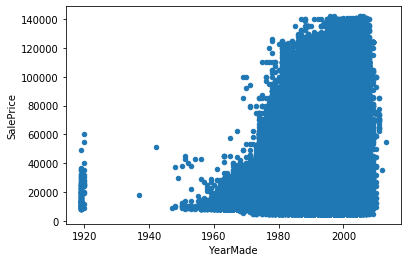

In [24]:
first_analysis.plot.scatter('YearMade', 'SalePrice')

# Drop Some Columns

In [45]:
auction_train.drop(columns=['UsageBand','Blade_Extension', 'Blade_Width', 'Enclosure_Type',
                           'Engine_Horsepower', 'Pushblock', 'Scarifier', 'Tip_Control',
                           'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
                           'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
                           'Differential_Type', 'Steering_Controls'], inplace=True)

In [48]:
auction_train.drop(columns='SalesID', inplace=True)

In [58]:
auction_train.drop(columns='fiBaseModel', inplace=True)

In [60]:
auction_train.drop(columns='fiSecondaryDesc', inplace=True)

In [62]:
auction_train.drop(columns='fiModelSeries', inplace=True)

In [64]:
auction_train.drop(columns='fiModelDescriptor', inplace=True)

In [65]:
auction_train.head()

,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saledate,fiModelDesc,ProductSize,...,Hydraulics,Ripper,Tire_Size,Coupler,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type
0,66000,999089,3157,121,3.0,2004,68.0,11/16/2006 0:00,521D,NaN,...,2 Valve,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN
1,57000,117657,77,121,3.0,1996,4640.0,3/26/2004 0:00,950FII,Medium,...,2 Valve,NaN,23.5,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN
2,10000,434808,7009,121,3.0,2001,2838.0,2/26/2004 0:00,226,NaN,...,Auxiliary,NaN,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN
3,38500,1026470,332,121,3.0,2001,3486.0,5/19/2011 0:00,PC120-6E,Small,...,2 Valve,NaN,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN
4,11000,1057373,17311,121,3.0,2007,722.0,7/23/2009 0:00,S175,NaN,...,Auxiliary,NaN,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN


# Convert MachineHoursCurrent Meter "NaN" values to the average value

In [54]:
auction_train['MachineHoursCurrentMeter'].fillna(auction_train['MachineHoursCurrentMeter'].mean(), inplace=True)

In [55]:
auction_train['MachineHoursCurrentMeter'].describe()

count    4.011250e+05
mean     3.457955e+03
std      1.645985e+04
min      0.000000e+00
25%      2.318000e+03
50%      3.457955e+03
75%      3.457955e+03
max      2.483300e+06
Name: MachineHoursCurrentMeter, dtype: float64

# Clean Ripper Values

In [67]:
auction_train['Ripper'].value_counts()

None or Unspecified    83452
Yes                     7902
Multi Shank             7633
Single Shank            5150
Name: Ripper, dtype: int64

In [74]:
# One Hot Encode Categoricals
def set_ohe(df:pd.DataFrame, col_name:str) -> None:
    for val in auction_train[col_name].value_counts().index:
        df[f"{col_name}: {val}"] = df[col_name].map(lambda x: 1.0 if x==val else 0.0 )
set_ohe(auction_train, "Ripper")

In [75]:
auction_train.head()

,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saledate,fiModelDesc,ProductSize,...,Multi Shank,Single Shank,RipperNone or Unspecified,RipperYes,RipperMulti Shank,RipperSingle Shank,Ripper None or Unspecified,Ripper Yes,Ripper Multi Shank,Ripper Single Shank
0,66000,999089,3157,121,3.0,2004,68.0,11/16/2006 0:00,521D,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,57000,117657,77,121,3.0,1996,4640.0,3/26/2004 0:00,950FII,Medium,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10000,434808,7009,121,3.0,2001,2838.0,2/26/2004 0:00,226,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,38500,1026470,332,121,3.0,2001,3486.0,5/19/2011 0:00,PC120-6E,Small,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11000,1057373,17311,121,3.0,2007,722.0,7/23/2009 0:00,S175,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Clean ProductSize Values

In [68]:
auction_train['ProductSize'].value_counts()

Medium            62274
Large / Medium    49678
Small             26494
Mini              24840
Large             20975
Compact            6089
Name: ProductSize, dtype: int64

# Clean YearMade Values

If year is 1000, make it the average year?

In [69]:
auction_train['YearMade'].value_counts()

1000    38185
1998    21221
2005    20587
2004    20020
1997    18905
        ...  
1949        1
1947        1
1942        1
1937        1
2013        1
Name: YearMade, Length: 72, dtype: int64

In [ ]:
auction_train['YearMade'].

## Restrictions
Please use only *regression* methods for this case study.  The following techniques 
are legal

  - Linear Regression.
  - Logistic Regression.
  - Median Regression (linear regression by minimizing the sum of absolute deviations).
  - Any other [GLM](http://statsmodels.sourceforge.net/devel/glm.html).
  - Regularization: Ridge and LASSO.

You may use other models or algorithms as supplements (for example, in feature
engineering), but your final submissions must be scores from a linear type
model.

## Important Tips

1. This data is quite messy. Try to use your judgement about where your
cleaning efforts will yield the most results and focus there first.
2. Because of the restriction to linear models, you will have to carefully
consider how to transform continuous predictors in your model.
3. Remember any transformations you apply to the training data will also have
to be applied to the testing data, so plan accordingly.
4. Any transformations of the training data that *learn parameters* (for
example, standardization learns the mean and variance of a feature) must only
use parameters learned from the *training data*.
5. It's possible some columns in the test data will take on values not seen in
the training data. Plan accordingly.
6. Use your intuition to *think about where the strongest signal about a price
is likely to come from*. If you weren't fitting a model, but were asked to use
this data to predict a price what would you do? Can you combine the model with
your intuitive instincts?  This is important because it can be done *without
looking at the data*; thinking about the problem has no risk of overfitting.
7. Start simply. Fit a basic model and make sure you're able to get the
submission working then iterate to improve. 
8. Remember that you are evaluated on a loss function that is only sensitive to
the *ratios* of predicted to actual values.  It's almost certainly too much of
a task to implement an algorithm that minimizes this loss function directly in
the time you have, but there are some steps you can take to do a good job of
it.    

## Overview of the score_model.py script
Included is a score function to test your predictions of the test set against the provided hold out test set.  This follows a common setup in competitions such as Kaggle, where this came from.  In these types of setups, there is a labeled train set to do your modeling and feature tuning.  There is also a provided hold-out test set to compare your predictions against.  You will need to fit a model on the training data and get a prediction for all the data in the test set.  You will then need to create csv containing the field 'SalesID' and 'SalePrice' (must match exactly).  This will be the input parameter to running the function.    
Example:
In terminal:
```
python score_model.py <path to csv file>
```


## Credit
This case study is based on [Kaggle's Blue Book for Bulldozers](https://www.kaggle.com/c/bluebook-for-bulldozers) competition.  The best RMSLE was only 0.23 (obviously lower is better).  Note
that if you were to simply guess the median auction price for all the pieces of equipment in
the test set you would get an RMSLE of about 0.7.